In [1]:
import pandas as pd
import numpy as np
import scipy as sc
from matplotlib import pyplot as plt
from skimage import io, transform, exposure, filters
import torch
import torch.nn as nn
import torch.nn.functional as tfunc
from torch.utils.data import Dataset, dataset
import torchvision
from torchvision.transforms import Compose
import os

In [2]:
class SaltSegmentationDataset :
    def __init__(self,image_dir,mask_dir=None,transform_sequence=None) :
        super(SaltSegmentationDataset,self).__init__()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = os.listdir(self.image_dir)
        self.transform_sequence = transform_sequence
    def __len__(self) :
        return len(self.images)
    def __getitem__(self,idx) :
        image = io.imread(self.image_dir+'/'+self.images[idx])
        if self.mask_dir :
            mask = io.imread(self.mask_dir+'/'+self.images[idx]) > 2
        else :
            mask = np.zeros_like(image)
        if self.transform_sequence :
            image,mask = self.transform_sequence([image,mask])
        image = image.transpose([2,0,1]).astype(np.float32)
        mask = mask[np.newaxis].astype(np.float32)
        return image,mask

In [3]:
def rotate(q) :
    im,ma = q 
    angle = np.random.randn()*15
    im = transform.rotate(im,angle)
    ma = transform.rotate(ma,angle)
    return im,ma

def hflip(q) :
    im,ma = q
    if np.random.randn() < 0 :
        im = im[::-1,:]
        ma = ma[::-1,:]
    return im,ma

def vflip(q) :
    im,ma = q
    if np.random.randn() < 0 :
        im = im[:,::-1]
        ma = ma[:,::-1]
    return im,ma

def standardize(q) :
    im,ma = q
    min_val, max_val = np.percentile(im,[1,99])
    im = np.clip(im,min_val,max_val)
    im = (im - min_val)/(max_val-min_val+1e-5)
    return im,ma

transform_sequence = Compose([
    hflip,
    vflip,
    standardize
])

tgs_X = SaltSegmentationDataset('train/images','train/masks',transform_sequence)
tgs_length = tgs_X.__len__()
tgs_train,tgs_val = dataset.random_split(tgs_X,[int(0.9*tgs_length),tgs_length-int(0.9*tgs_length)])

Num_Samples 4000


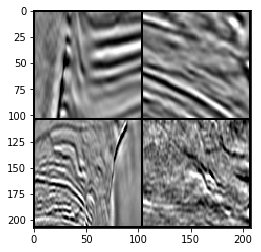

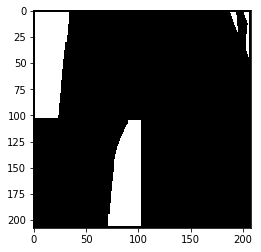

In [4]:
def imshow(dataset) :
    image,mask = next(iter(torch.utils.data.DataLoader(dataset,batch_size=4,shuffle=True)))
    inp = torchvision.utils.make_grid(image,nrow=2)
    plt.imshow(inp.permute(1, 2,0))
    plt.show()
    inp = torchvision.utils.make_grid(mask,nrow=2)
    plt.imshow(inp.permute(1, 2,0))
    plt.show()
print("Num_Samples",len(tgs_X))
imshow(tgs_X)

In [5]:
class BasicBlock(nn.Sequential) :
    def __init__(self,in_features,out_features,dilation) :
        super(BasicBlock,self).__init__()
        self.add_module('norm0',nn.InstanceNorm2d(in_features))
        self.add_module('conv0',nn.Conv2d(in_features,out_features,3,padding=dilation,dilation=dilation))
        self.add_module('act0',nn.LeakyReLU())
        self.add_module('norm1',nn.InstanceNorm2d(out_features))
        self.add_module('conv1',nn.Conv2d(out_features,out_features,3,padding=dilation,dilation=dilation))
        self.add_module('act1',nn.LeakyReLU())

class ResidualBlock(nn.Module) :
    def __init__(self,in_features,out_features,dilation) :
        super(ResidualBlock,self).__init__()
        self.block0 = BasicBlock(in_features,out_features,1)
        self.block1 = BasicBlock(out_features,out_features,dilation)
    def forward(self,x) :
        x = self.block0(x)
        x = x + self.block1(x)
        return x
        
class UpSampleBlock(nn.Module) :
    def __init__(self,in_features,out_features,dilation) :
        super(UpSampleBlock,self).__init__()
        self.block = ResidualBlock(in_features,out_features,dilation)
    def forward(self,u_shortcut,prev_x,use_shortcuts) :
        prev_x = tfunc.interpolate(prev_x,size = u_shortcut.shape[2:],mode='bilinear',align_corners=True)
        x = torch.cat([u_shortcut*use_shortcuts,prev_x],dim=1)
        x = self.block(x)
        return x

class DownSampleBlock(nn.Module) :
    def __init__(self,in_features,out_features,dilation) :
        super(DownSampleBlock,self).__init__()
        self.block = ResidualBlock(in_features,out_features,dilation)
    def forward(self,prev_x) :
        x = self.block(prev_x)
        x = tfunc.avg_pool2d(x,2)
        return x

class DruNet(nn.Module) :
    def __init__(self,input_channels=3,init_channels = 32, dilation_rates = [1,2,4,8],n_classes=1) :
        super(DruNet,self).__init__()
        self.initial_conv = nn.Conv2d(input_channels,init_channels,3,padding=1)
        self.downsample_blocks = nn.ModuleList() 
        f = init_channels
        for i,d in enumerate(dilation_rates) :
            self.downsample_blocks.append(DownSampleBlock(f,2*f,d))
            f = 2*f
        
        self.encoder = BasicBlock(f,f//2,dilation_rates[-1])
        f = f//2
        self.upsample_blocks = nn.ModuleList() 
        for i,d in enumerate(dilation_rates[::-1][1:]+[1]) :
            self.upsample_blocks.append(UpSampleBlock(2*f,f//2,d))
            f = f//2
        self.classifier = nn.Conv2d(f,n_classes,1)
    def forward(self,x,use_shortcuts=1.,debug=False) :
        x = self.initial_conv(x)
        connections = [x]
        for i,layer in enumerate(self.downsample_blocks) :
            x = layer(x)
            connections.append(x)
        connections_length = len(connections)
        x = self.encoder(x)
        connections.append(x)
        for i,layer in enumerate(self.upsample_blocks) :
            shortcut_x = connections[connections_length - 2 - i]
            x = layer(shortcut_x,x,use_shortcuts)
            connections.append(x)
        mask = self.classifier(x)
        if debug == True :
            return mask,connections
        return mask
            

In [6]:
import torch.optim as optim
def train(net,lr,wd,dataset,loss_fn) :
    net.train()
    optimizer = optim.Adam(net.parameters(),lr=lr,weight_decay=wd)
    for x,y in dataset :
        x = x.cuda()
        y = y.cuda()
        optimizer.zero_grad()
        y_pred = net(x)
        loss_fn(y_pred,y).backward()
        optimizer.step()

def train_warm(net,lr,wd,dataset,loss_fn) :
    net.train()
    optimizer = optim.Adam(net.parameters(),lr=lr,weight_decay=wd)
    for x,y in dataset :
        x = x.cuda()
        y = y.cuda()
        optimizer.zero_grad()
        y_pred = net(x,use_shortcuts=0)
        loss_fn(y_pred,y).backward()
        optimizer.step()
        
def inference(net,dataset,loss_fn) :
    loss = 0
    with torch.no_grad() :
        net.eval()
        for x,y in dataset :
            x = x.cuda()
            y = y.cuda()
            y_pred = net(x)
            loss += loss_fn(y_pred,y).detach().cpu().numpy()
    inp = torchvision.utils.make_grid(x.cpu(),nrow=4)
    plt.imshow(inp.permute(1, 2,0))
    plt.show()
    inp = torchvision.utils.make_grid(torch.sigmoid(y_pred).cpu(),nrow=4)
    plt.imshow(inp.permute(1, 2,0))
    plt.show()
    inp = torchvision.utils.make_grid(y.cpu(),nrow=4)
    plt.imshow(inp.permute(1, 2,0))
    plt.show()
    return loss/dataset.dataset.__len__()

def run_epoch(net,lr,batch_size,train_dataset,val_dataset,train_loss,val_loss,max_epochs,warm_epochs=10,wd=0) :
    train_losses = []
    val_losses = []
    test_losses = []
    train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=batch_size)
    
    for i in range(max_epochs+1) :
        if i < warm_epochs :
            train_warm(net,lr,wd,train_loader,train_loss)
        else :
            train(net,lr,wd,train_loader,train_loss)
        if i%5 == 0:
            train_losses.append(inference(net,train_loader,val_loss))
            val_losses.append(inference(net,val_loader,val_loss))
            torch.save(net.state_dict(),'{}_epoch.mod'.format(i))
            print("epoch : {},train_loss : {},val_loss : {}".format(i,train_losses[-1],val_losses[-1]))
    return train_losses,val_losses
       

In [7]:
def dce_loss(inp,target,use_sigmoid = False) :
    if use_sigmoid :
        inp = torch.sigmoid(inp)
    else :
        inp = torch.ge(inp,0.).type_as(inp)
    inp = inp.view(inp.shape[0],-1)
    target = target.view(target.shape[0],-1)
    intersection = (inp*target).sum(dim=1)
    union = (inp+target).sum(dim=1)
    dce = -torch.log((2*intersection+1e-5)/(union+1e-5)).mean()
    return dce

def focal_loss(inp,target,gamma = 1.5) :
    log_probs = tfunc.binary_cross_entropy_with_logits(inp,target,reduction='none')
    pt = torch.exp(-log_probs)
    focal_loss = torch.pow(1-pt,gamma)*log_probs
    focal_loss = focal_loss.mean()
    return focal_loss


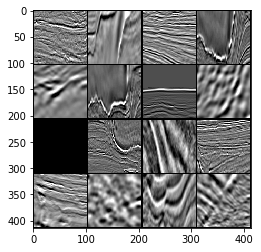

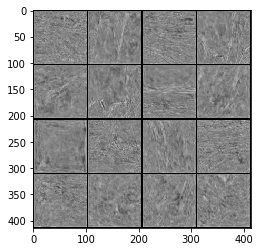

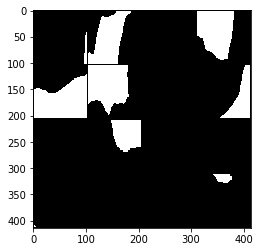

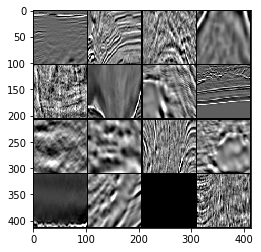

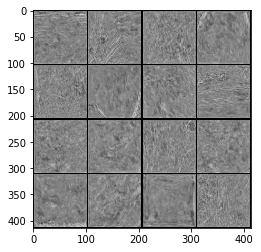

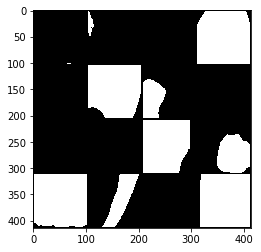

epoch : 0,train_loss : 0.2752572151025136,val_loss : 0.2793473529815674


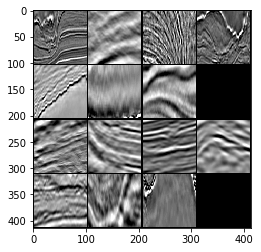

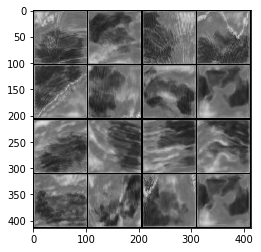

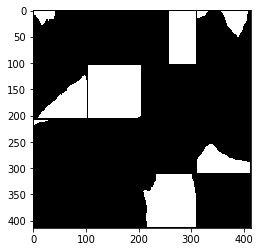

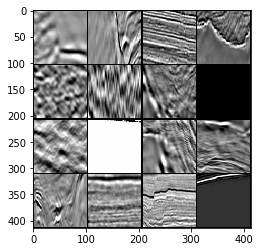

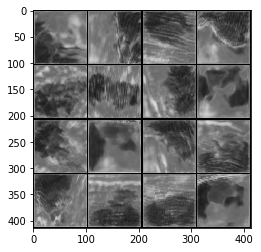

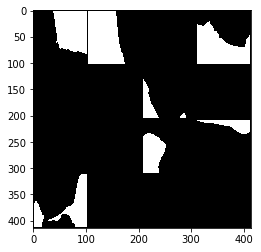

epoch : 5,train_loss : 0.2593748766846127,val_loss : 0.26934059023857115


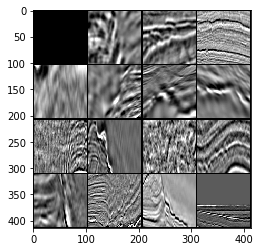

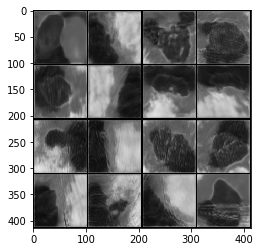

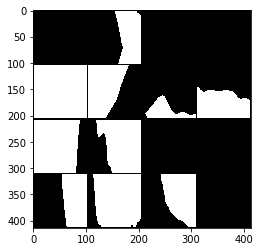

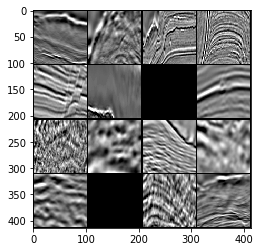

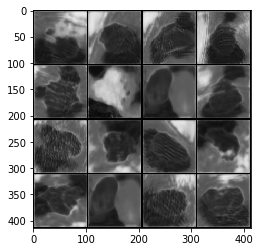

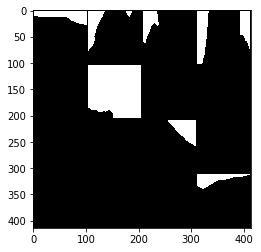

epoch : 10,train_loss : 0.23482426232761808,val_loss : 0.24978803873062133


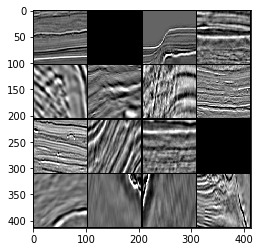

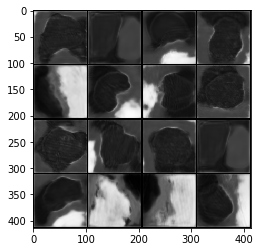

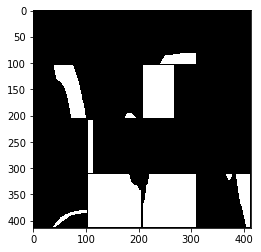

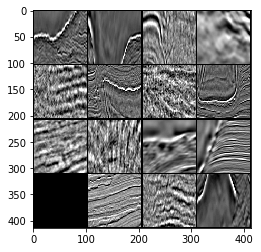

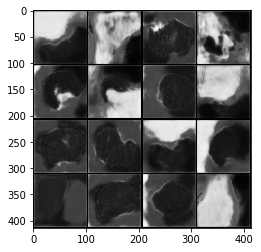

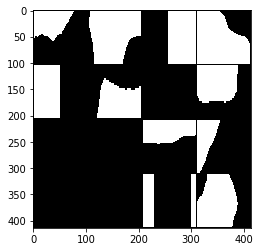

epoch : 15,train_loss : 0.19187775373458862,val_loss : 0.21676599621772766


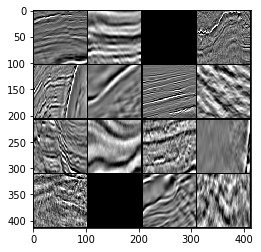

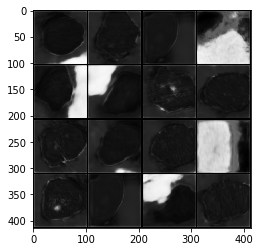

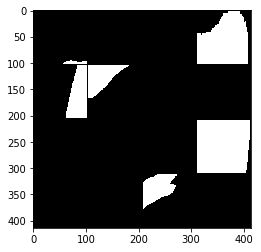

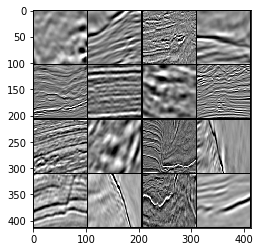

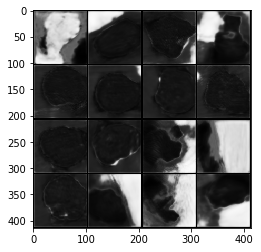

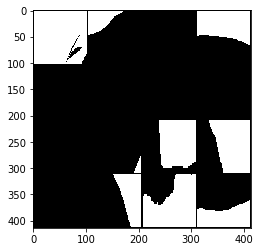

epoch : 20,train_loss : 0.1075249925090207,val_loss : 0.16920668244361878


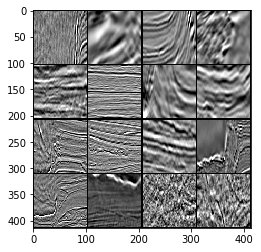

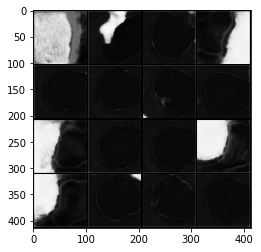

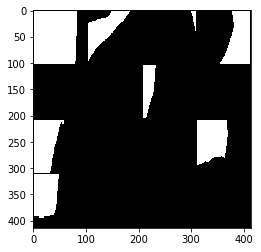

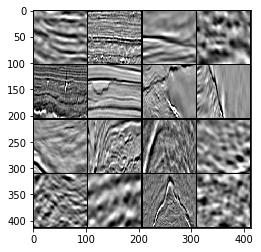

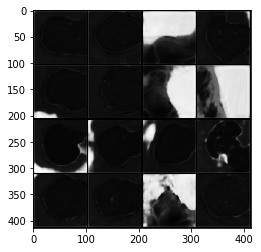

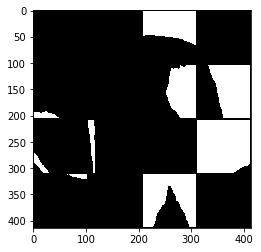

epoch : 25,train_loss : 0.0468692131816513,val_loss : 0.13940281748771668


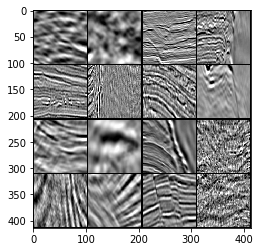

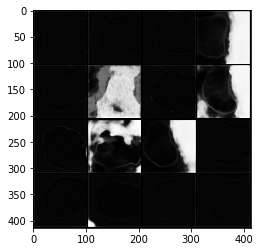

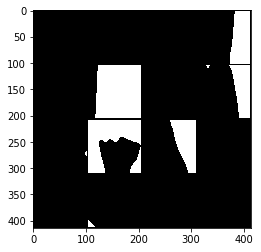

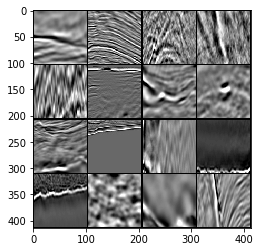

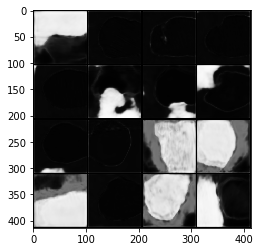

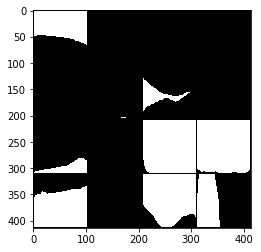

epoch : 30,train_loss : 0.04088929811492562,val_loss : 0.12891443699598312


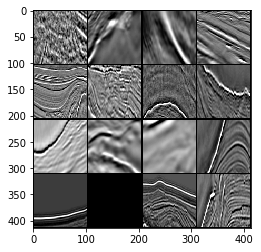

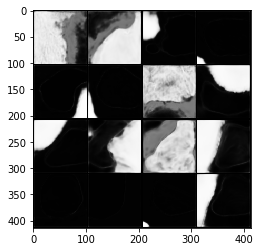

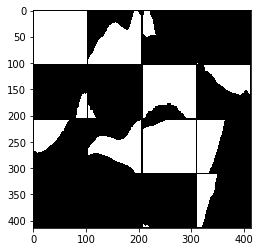

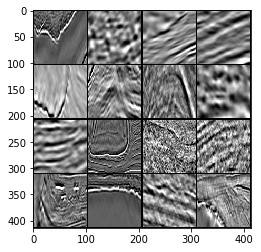

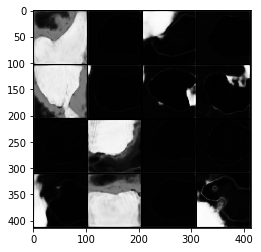

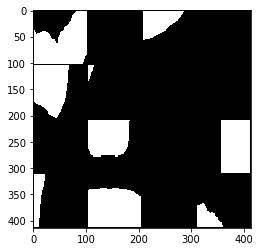

epoch : 35,train_loss : 0.026480713763998614,val_loss : 0.12422312676906586


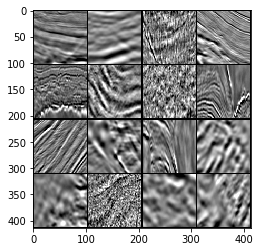

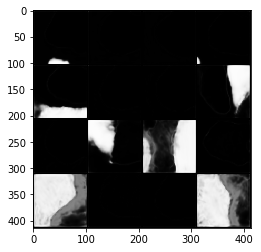

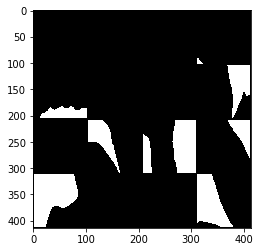

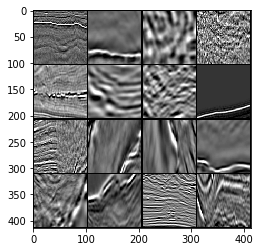

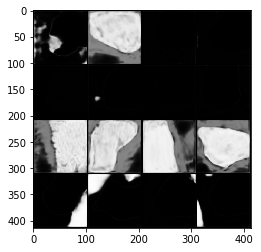

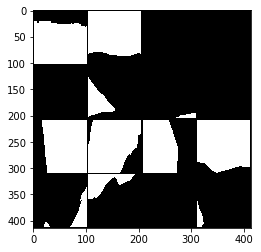

epoch : 40,train_loss : 0.01566175444258584,val_loss : 0.09466160714626312


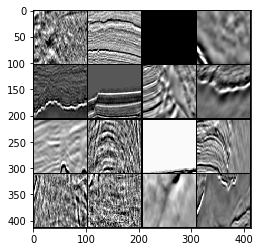

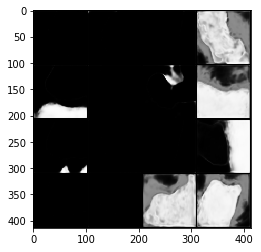

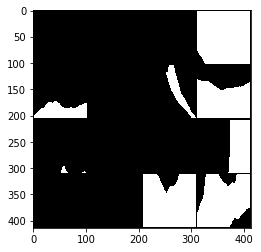

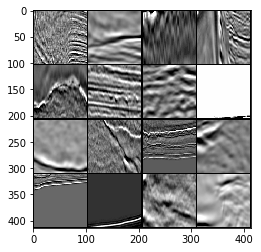

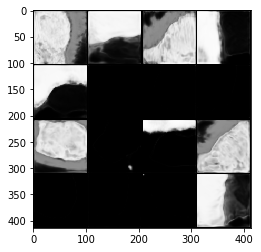

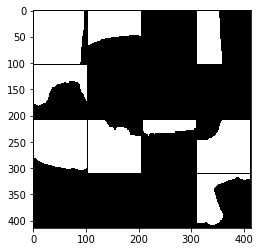

epoch : 45,train_loss : 0.01156256443200012,val_loss : 0.09479032516479492


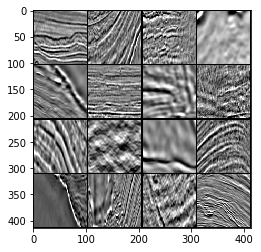

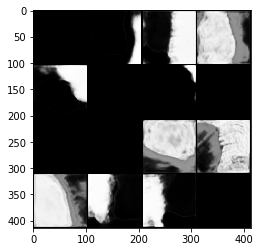

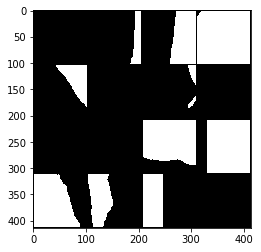

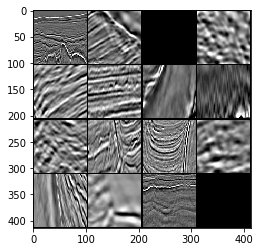

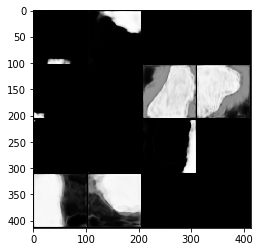

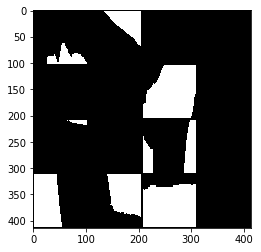

epoch : 50,train_loss : 0.012986146381331814,val_loss : 0.0871873614192009


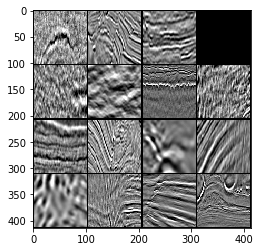

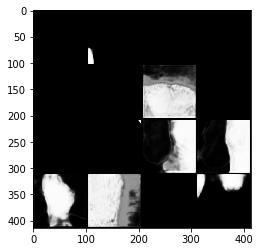

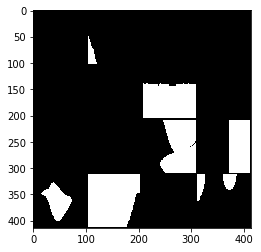

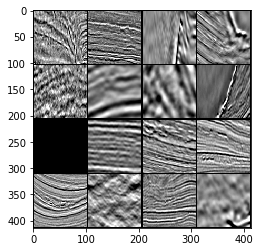

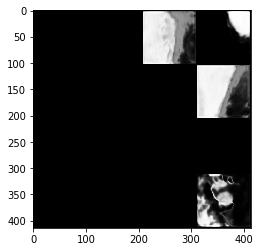

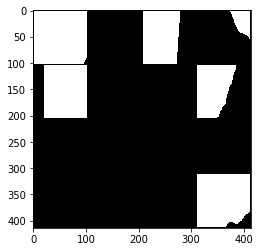

epoch : 55,train_loss : 0.010593625629941622,val_loss : 0.09609548538923264


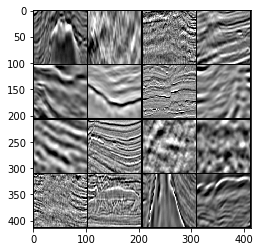

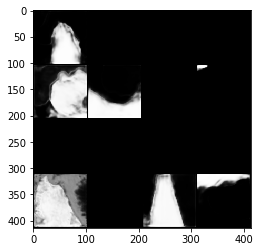

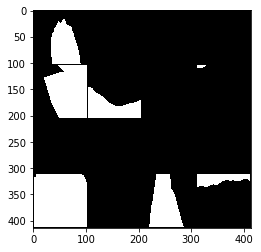

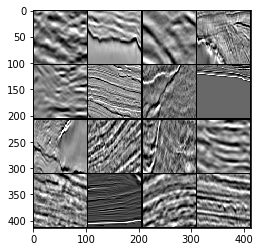

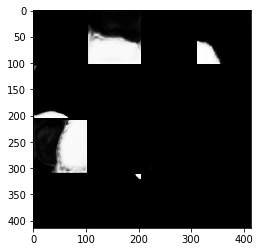

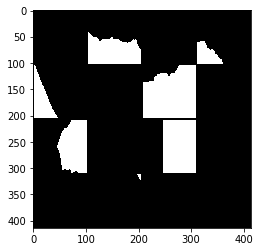

epoch : 60,train_loss : 0.009427459621801972,val_loss : 0.09414605468511582


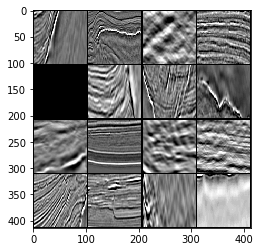

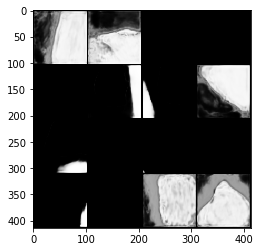

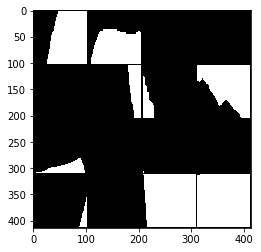

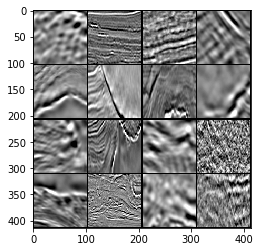

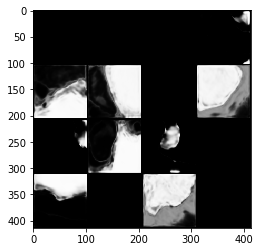

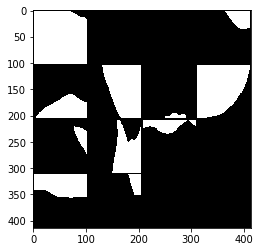

epoch : 65,train_loss : 0.009644668355791105,val_loss : 0.08371773928403854


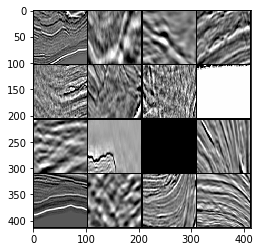

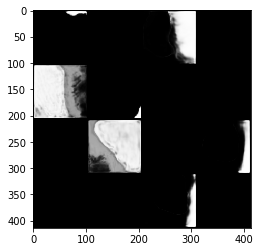

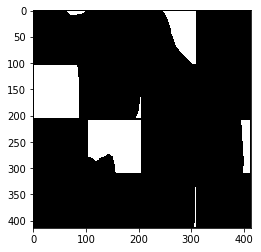

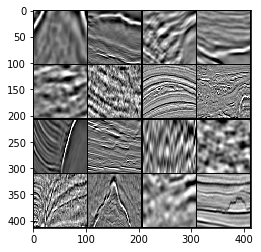

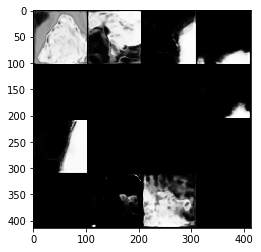

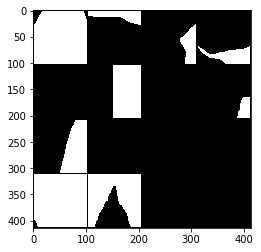

epoch : 70,train_loss : 0.012379913170718484,val_loss : 0.08918673172593117


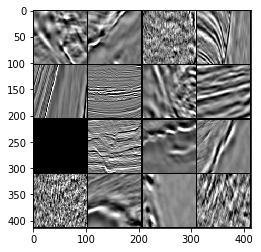

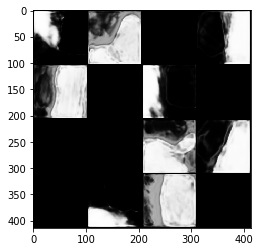

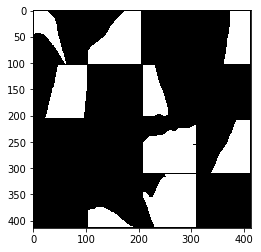

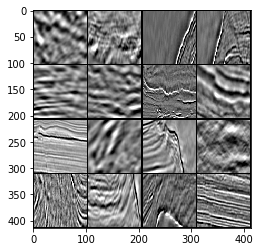

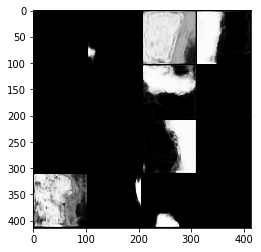

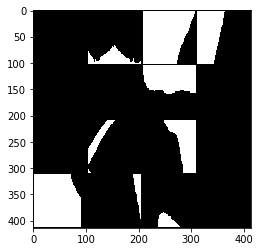

epoch : 75,train_loss : 0.008644621807874904,val_loss : 0.0862617912888527


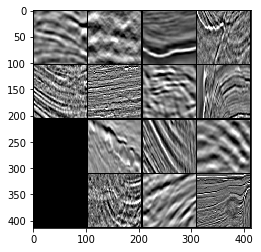

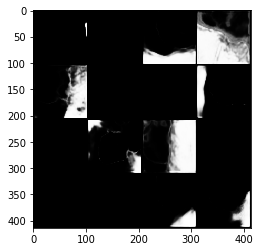

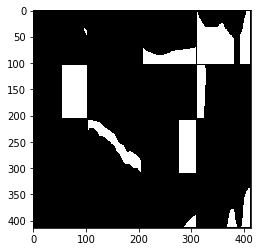

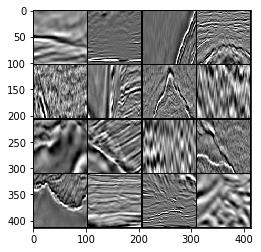

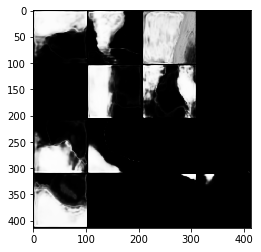

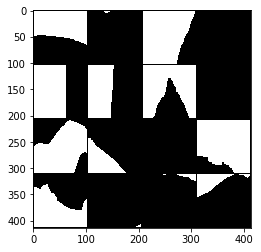

epoch : 80,train_loss : 0.010761533431294892,val_loss : 0.08909361839294433


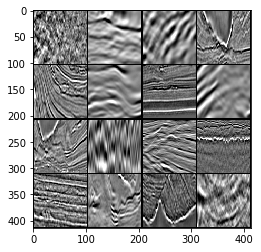

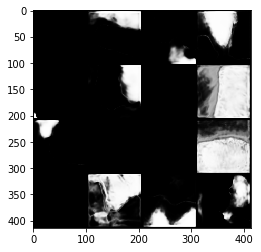

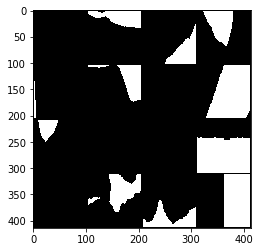

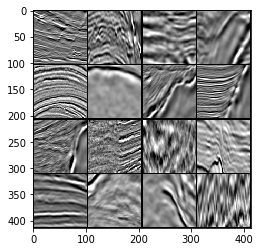

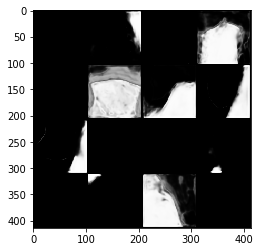

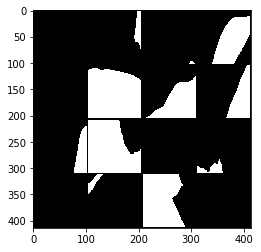

epoch : 85,train_loss : 0.008445699809946947,val_loss : 0.08744432076811791


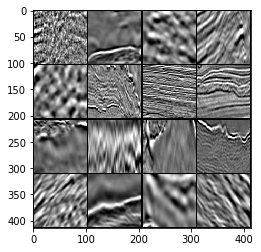

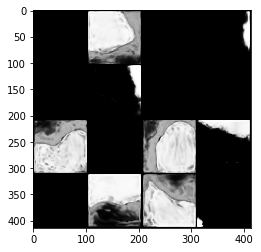

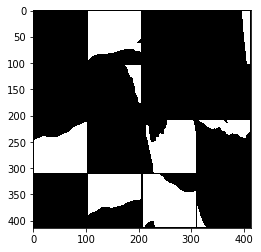

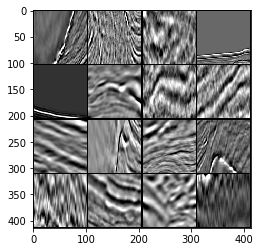

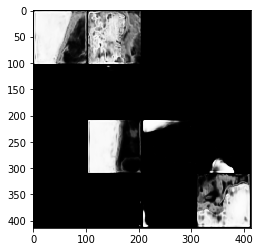

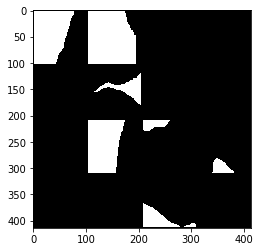

epoch : 90,train_loss : 0.00940072379178471,val_loss : 0.09759217493236065


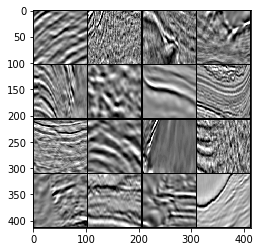

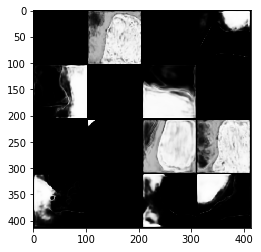

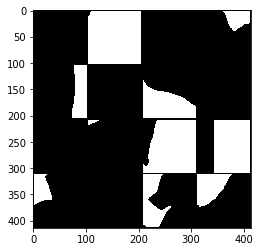

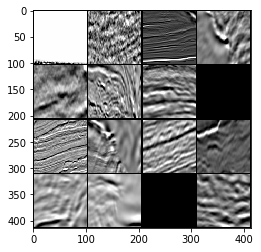

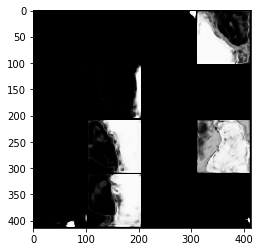

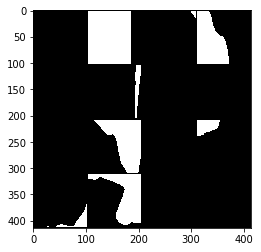

epoch : 95,train_loss : 0.008055943643881215,val_loss : 0.0784631198644638


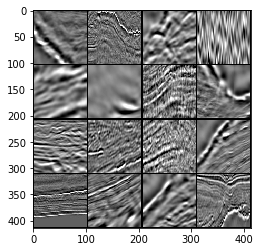

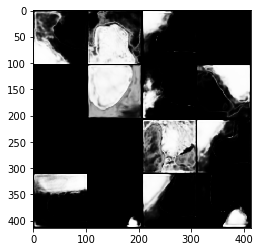

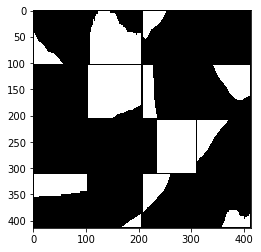

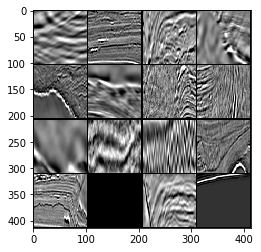

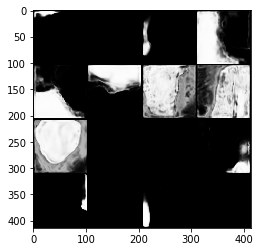

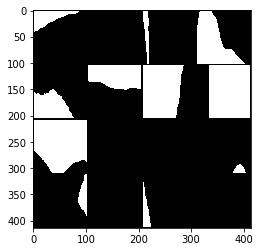

epoch : 100,train_loss : 0.014082143319149813,val_loss : 0.087523927167058


In [8]:
train_loss = lambda x,y : dce_loss(x,y,True) +focal_loss(x,y)
val_loss = lambda x,y : dce_loss(x,y)
net = DruNet()
net = net.cuda()
tl,vl = run_epoch(net,1e-5,32,tgs_train,tgs_val,train_loss,val_loss,100)

In [9]:
torch.cuda.empty_cache()
net.load_state_dict(torch.load('{}_epoch.mod'.format(np.argmin(vl)*5)))
tgs_testX = SaltSegmentationDataset('test/images',None,None)

def rle_encode(im):
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

test_loader = torch.utils.data.DataLoader(tgs_testX,shuffle=False,batch_size=32)
def get_mask(net,dataset) :
    masks = []
    with torch.no_grad() :
        net.eval()
        for x,y in dataset :
            x = x.cuda()
            y = y.cuda()
            y_pred = net(x)
            mask = torch.ge(y_pred,0.).cpu().numpy().astype(np.int)
            masks = masks + [rle_encode(i) for i in mask]
    return masks

masks = np.array(get_mask(net,test_loader)).reshape((-1,1))
images = np.array(tgs_testX.images).reshape((-1,1))
output = np.hstack([images,masks])
df = pd.DataFrame(output,columns = ['id','rle_mask'])
print(df.head())
df.to_csv('output.csv',index=False)


               id                                           rle_mask
0  0005bb9630.png                                                   
1  000a68e46c.png                                                   
2  000c8dfb2a.png  85 8 187 7 288 7 435 7 537 7 945 3 3068 4 3171...
3  000d0a5f6c.png  51 11 151 12 252 12 353 10 454 8 555 6 655 6 7...
4  001ef8fc87.png  7 92 106 95 205 2 208 20 232 18 293 10 306 45 ...


In [10]:
print(df.shape)
df = pd.read_csv('output.csv')
l = pd.read_csv('sample_submission.csv')
l['id'] = l['id'] + '.png'
print(set(l['id'].values.tolist()) - set(df['id'].values.tolist()))
print( set(df['id'].values.tolist())-set(l['id'].values.tolist()) )
l1  = l.merge(df,on='id')
print(l1.shape)

(18000, 2)
set()
set()
(18000, 3)
